### Import Dependency

In [182]:
from pydantic import BaseModel, Field

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages import convert_to_openai_messages

from jinja2 import Template
from typing import List, Dict, Any, Annotated, Literal
from IPython.display import Image, display

from operator import add
from openai import OpenAI

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message



#### Single node lang graph



In [101]:
class State(BaseModel):
    message: str
    answer: str = ""
    vibe: str

In [102]:
def append_vibes_to_query(state:State) -> dict:

    return {
        "answer": f"{state.message} {state.vibe}"
    }

In [103]:
workflow = StateGraph(State)

workflow.add_node("append_vibes_to_query", append_vibes_to_query)

workflow.add_edge(START, "append_vibes_to_query")

workflow.add_edge("append_vibes_to_query", END)
graph = workflow.compile()

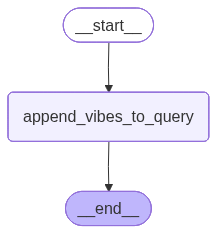

In [104]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [105]:
initial_state = {
    "message":"What is Pihu doing?", 
    "vibe":"feeling happy"
    }

In [106]:
initial_state

{'message': 'What is Pihu doing?', 'vibe': 'feeling happy'}

In [107]:
result = graph.invoke(initial_state)
result


{'message': 'What is Pihu doing?',
 'answer': 'What is Pihu doing? feeling happy',
 'vibe': 'feeling happy'}

#### Conditional graph

In [108]:
class State(BaseModel):
    message: str
    answer: str = ""
    

In [109]:
def append_vibes_to_query(state:State) -> dict:

    return {
        "answer": "I am here to add some vibes"
    }

In [110]:
def router(state:State) -> Literal["append_vibe_1", "append_vibe_2", "append_vibe_3"]:
    vibes = ["append_vibe_1", "append_vibe_2", "append_vibe_3"]
    vibe_path = random.choice(vibes)
    return vibe_path

In [111]:
def append_vibe_1(state:State) -> dict:
    vibe = "happy"
    return {
        "answer": f"{state.answer} {state.message} I am feeling {vibe} today!"
    }
def append_vibe_2(state:State) -> dict:
    vibe = "joyful"
    return {
        "answer": f"{state.answer} {state.message} I am feeling {vibe} today!"
    }
def append_vibe_3(state:State) -> dict:
    vibe = "excited"
    return {
        "answer": f"{state.answer} {state.message} I am feeling {vibe} today!"
    }


In [112]:
workflow = StateGraph(State)

workflow.add_node("append_vibes_to_query", append_vibes_to_query)

workflow.add_node("append_vibe_1", append_vibe_1)

workflow.add_node("append_vibe_2", append_vibe_2)   

workflow.add_node("append_vibe_3", append_vibe_3)

workflow.add_edge(START, "append_vibes_to_query")

workflow.add_conditional_edges("append_vibes_to_query", router)

workflow.add_edge("append_vibe_1", END)

workflow.add_edge("append_vibe_2", END)

workflow.add_edge("append_vibe_3", END)


In [113]:
graph = workflow.compile()

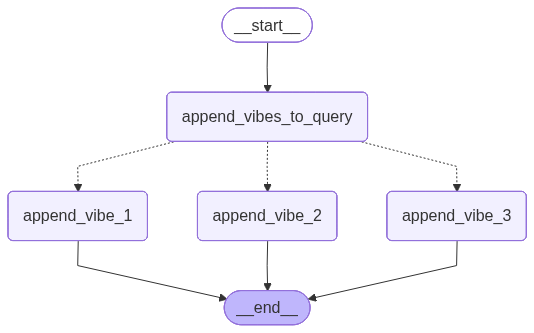

In [114]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [115]:
initial_state = {
    "message": "Give me some vibes"
}
result = graph.invoke(initial_state)
result


{'message': 'Give me some vibes',
 'answer': 'I am here to add some vibes Give me some vibes I am feeling happy today!'}

### Agent graph

#### useful & important to add documentation like below function for tool functions for LLMs to understand and use functions properly. There are utils as well that can generate these docs.
##### Hands on video has an example implementation of such a function // get_tool_description()

In [183]:
def append_vibes(query:str, vibe:str) -> str:
    """Takes in a query and a vibe and returns a string with the vibe appended to the query
    Args:
        query: str - The query to append the vibe to
        vibe: str - The vibe to append to the query
    Returns:
        str: A string with the vibe appended to the query
    """
    return f"{query} {vibe}"




In [184]:
get_tool_descriptions([append_vibes])

[{'name': 'append_vibes',
  'description': 'Takes in a query and a vibe and returns a string with the vibe appended to the query',
  'parameters': {'type': 'object',
   'properties': {'query': {'type': 'string',
     'description': 'str - The query to append the vibe to'},
    'vibe': {'type': 'string',
     'description': 'str - The vibe to append to the query'}}},
  'required': ['query', 'vibe'],
  'returns': {'type': 'string',
   'description': 'str: A string with the vibe appended to the query'}}]

In [122]:
class ToolCall(BaseModel):
    name: str
    arguments: dict


In [123]:
class AgentResponse(BaseModel):
    answer: str
    tool_calls: List[ToolCall] = Field(default_factory=list)


In [ ]:
class State(BaseModel):
    messages: Annotated[List[Any], add] = [] # list of llm messages history, Annotated is used to add metadata to the field instead of overriding the default value - maintains the history of messages
    message: str = "" # user query
    iteration: int = 0 # number of iterations so agent can call tools multiple times if needed
    answer: str = "" # answer to the user query
    available_tools: List[Dict[str, Any]] = [] # list of tools available to use
    tool_calls: List[ToolCall] = [] # list of tool calls to use

In [185]:
def agent_node(state: State) -> dict:

    prompt_template = """You are a assistant that is generating vibes for a user.
    You will be given a selection of tools you can use to add randomly generated vibes to the user's query.
    Vibes can be anything from happy, joyful, excited, etc. Don't be afraid to be creative and add some unique vibes instead of limiting yourself to the ones provided!

    <Available_Tools>
    {{ available_tools | tojson }}
    </Available_Tools>

    When you need to use a tool, format your response as:

    <tool_call>
    {"name": "tool_name", "arguments": {...}}
    </tool_call>

    Instructions:
    - You need to use the tools to add vibes to the user's query
    - Add a randomly generated vibe to the user's query
    """

    template = Template(prompt_template)

    prompt = template.render(available_tools=state.available_tools)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, {"role": "user", "content": state.message}],
        temperature=0.5
    )
    # lang chain has its own format_ai_message function, we are not using it here.
    ai_message = format_ai_message(response)

    return {
        "messages": [ai_message],
        "tool_calls": response.tool_calls
    }


In [186]:
def tool_router(state:State) -> str:
    """Decide whenther to continue or end"""
    if len(state.tool_calls) > 0:
        return "tools"
    else:
        return END


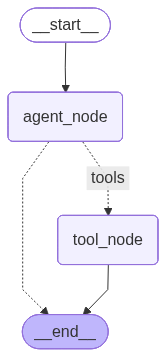

In [187]:
workflow = StateGraph(State)

tools = [append_vibes]

tool_node = ToolNode(tools)

tool_descriptions = get_tool_descriptions(tools)

workflow.add_node("agent_node", agent_node)

workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")

workflow.add_conditional_edges(
    "agent_node",
    tool_router, 
    {
        "tools": "tool_node",
        END: END
    }
)

workflow.add_edge("tool_node", END)

graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [188]:
initial_state = {
    "message": "Give me some vibes", 
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)
result

{'messages': [AIMessage(content='Here are some vibes for you!', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Give me some vibes', 'vibe': 'chill and uplifting'}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='Give me some vibes chill and uplifting', name='append_vibes', tool_call_id='call_0')],
 'message': 'Give me some vibes',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Takes in a query and a vibe and returns a string with the vibe appended to the query',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'description': 'str - The query to append the vibe to'},
     'vibe': {'type': 'string',
      'description': 'str - The vibe to append to the query'}}},
   'required': ['query', 'vibe'],
   'returns': {'type': 'string',
    'description': 'str: A string with the vibe appended to the query'}}],
 'tool_calls': [ToolCall(name='append_vibes', arguments={'quer

### Adding more variations to the same graph

#### iterations limit

In [ ]:
def agent_node(state: State) -> dict:

    prompt_template = """You are a assistant that is generating vibes for a user.
    You will be given a selection of tools you can use to add randomly generated vibes to the user's query.
    Vibes can be anything from happy, joyful, excited, etc. Don't be afraid to be creative and add some unique vibes instead of limiting yourself to the ones provided!

    <Available_Tools>
    {{ available_tools | tojson }}
    </Available_Tools>

    When you need to use a tool, format your response as:

    <tool_call>
    {"name": "tool_name", "arguments": {...}}
    </tool_call>

    Instructions:
    - You need to use the tools to add vibes to the user's query
    - Add a randomly generated vibe to the user's query
    - Do not ask for permission to use the tools, just use them
    - You must return a tool call in the first interaction
    """

    template = Template(prompt_template)

    prompt = template.render(available_tools=state.available_tools)

    messages = state.messages
    #  this util converts the messages to the format that openai expects
    # passing this to the model will allow the model to understand the conversation history
    conversation = convert_to_openai_messages(messages)

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AgentResponse,
        messages=[{"role": "system", "content": prompt}, *conversation],
        temperature=0.5
    )
    # lang chain has its own format_ai_message function, we are not using it here.
    ai_message = format_ai_message(response)

    return {
        "messages": [ai_message],
        "tool_calls": response.tool_calls,
        "iteration": state.iteration + 1,
        "answer": response.answer
    }


In [208]:
def tool_router(state:State) -> str:
    """Decide whenther to continue or end"""
    if state.iteration > 1:
        return END
    
    elif len(state.tool_calls) > 0:
        return "tools"
    else:
        return END

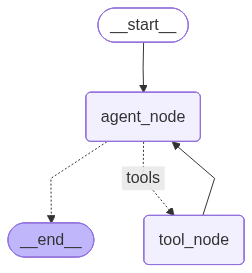

In [209]:
workflow = StateGraph(State)

tools = [append_vibes]

tool_node = ToolNode(tools)

tool_descriptions = get_tool_descriptions(tools)

workflow.add_node("agent_node", agent_node)

workflow.add_node("tool_node", tool_node)

workflow.add_edge(START, "agent_node")
workflow.add_edge("tool_node", "agent_node")

workflow.add_conditional_edges(
    "agent_node",
    tool_router, 
    {
        "tools": "tool_node",
        END: END
    }
)


graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [210]:
initial_state = {
    "message": "Give me some vibes", 
    "available_tools": tool_descriptions
}
result = graph.invoke(initial_state)
result

{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Generate vibes for me', 'vibe': 'vibrant and uplifting'}, 'id': 'call_0', 'type': 'tool_call'}]),
  ToolMessage(content='Generate vibes for me vibrant and uplifting', name='append_vibes', tool_call_id='call_0'),
  AIMessage(content='Generate vibes for me vibrant and uplifting', additional_kwargs={}, response_metadata={}, tool_calls=[{'name': 'append_vibes', 'args': {'query': 'Generate vibes for me', 'vibe': 'vibrant and uplifting'}, 'id': 'call_0', 'type': 'tool_call'}])],
 'message': 'Give me some vibes',
 'iteration': 2,
 'answer': 'Generate vibes for me vibrant and uplifting',
 'available_tools': [{'name': 'append_vibes',
   'description': 'Takes in a query and a vibe and returns a string with the vibe appended to the query',
   'parameters': {'type': 'object',
    'properties': {'query': {'type': 'string',
      'description': 'str - The query to a